###1. Set up training environment

In [ ]:
#Get necessary packages downloaded
#May take a few minutes
#This does not have to be run again if you restart a runtime, only if you terminate, are disconnected, or factory reset it
!pip install pytorch_lightning
!pip install torchsummaryX
!pip install webdataset
!pip install datasets
!pip install wandb
!git clone https://github.com/black0017/MedicalZooPytorch.git
!pip install -r MedicalZooPytorch/installation/requirements.txt
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
!git clone https://github.com/McMasterAI/Radiology-and-AI.git

#####If you make a change to a branch of the repo and want this script to reflect those changes, restart the runtime and run the code here, then the below imports again

In [ ]:
!rm -r ./Radiology-and-AI

In [ ]:
!git clone --branch <branchname> https://github.com/McMasterAI/Radiology-and-AI.git

#####Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('./Radiology-and-AI/Radiology_and_AI')
sys.path.append('./MedicalZooPytorch')
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from pytorch_lightning.loggers import WandbLogger
import pytorch_lightning as pl
import sys
import nibabel as nb
from skimage import transform
import matplotlib.pyplot as plt
import webdataset as wds
from collators.brats_collator import col_img
from lightning_modules.segmentation import TumourSegmentation

In [ ]:
cd drive/MyDrive

/content/drive/MyDrive


###2. Load Data 

In [ ]:
#Loading data, must have shortcut to the shared macai_datasets folder in the base level of your google drive
train_dataset = wds.Dataset("macai_datasets/brats/train/brats_train.tar.gz")
eval_dataset = wds.Dataset("macai_datasets/brats/validation/brats_validation.tar.gz")

###3. Load Lightning Module

In [ ]:
model = TumourSegmentation(learning_rate = 1e-4, collator=col_img, batch_size=5, train_dataset=train_dataset, eval_dataset=eval_dataset)

###4. Train

In [ ]:
wandb_logger = WandbLogger(project='macai',name='test_run', offline = True)

#Training
trainer = pl.Trainer(
    accumulate_grad_batches = 1,
    gpus = 1,
    max_epochs = 10,
    precision=16,
    check_val_every_n_epoch = 1,
    logger = wandb_logger,
    log_every_n_steps=10,            
)

trainer.fit(model)

In [9]:
#Run after youre done training and the run will be uploaded to wandb
!wandb sync --sync-all

Syncing: https://wandb.ai/dufaultc/macai/runs/2jbnz20l ...done.


###5. Evaluate

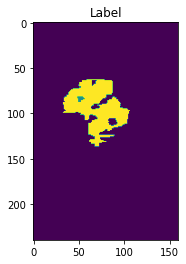

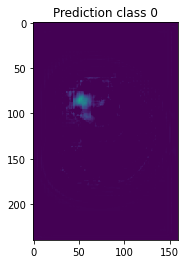

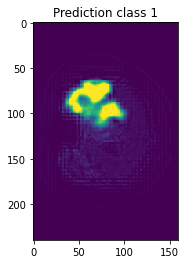

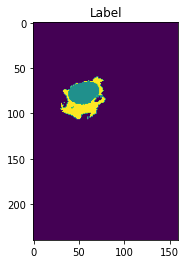

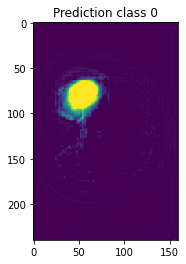

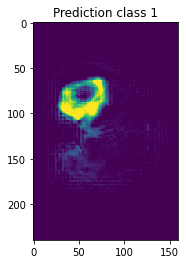

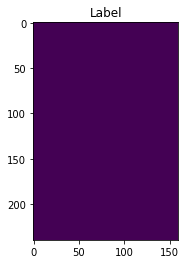

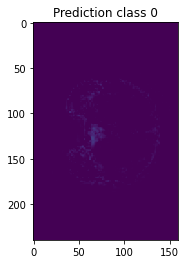

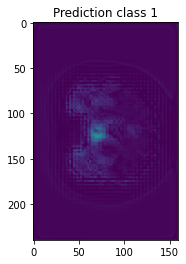

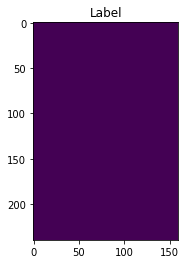

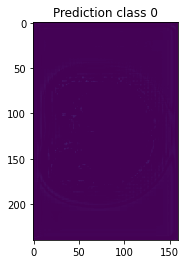

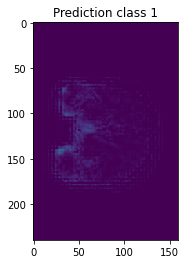

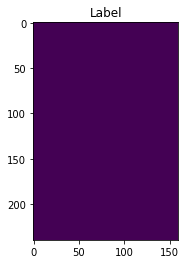

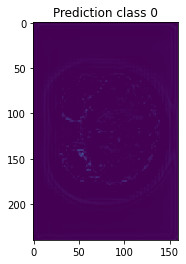

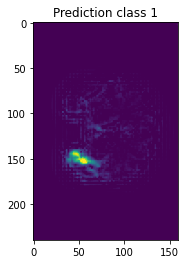

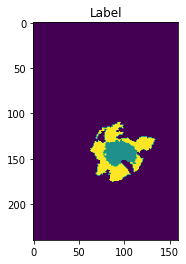

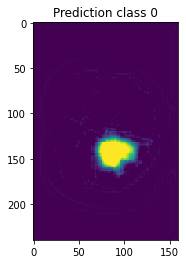

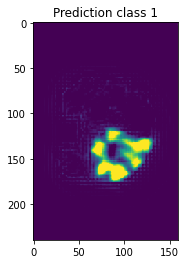

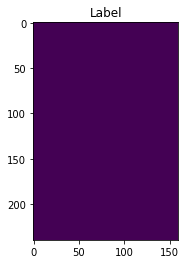

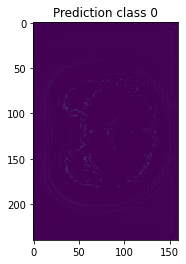

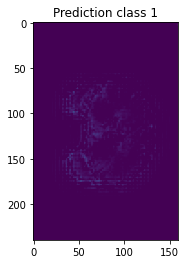

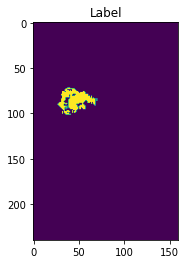

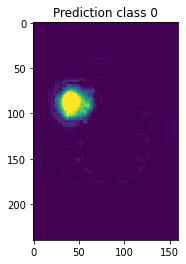

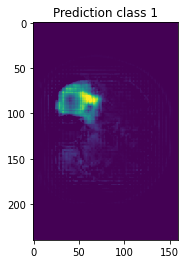

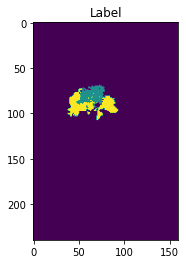

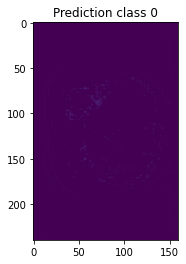

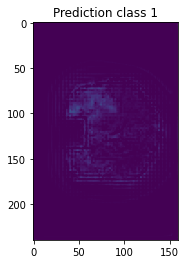

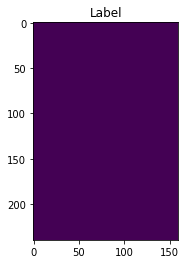

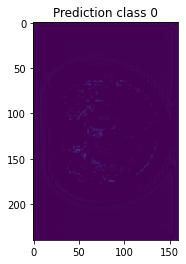

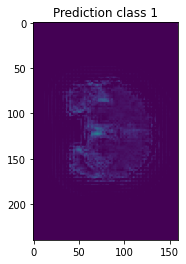

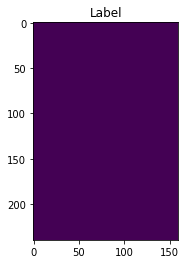

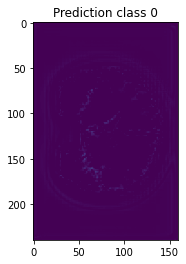

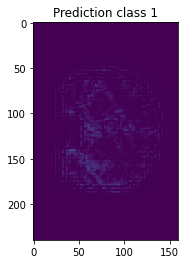

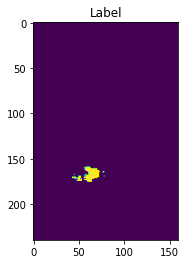

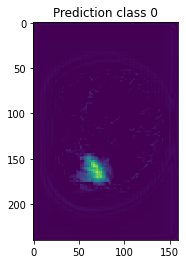

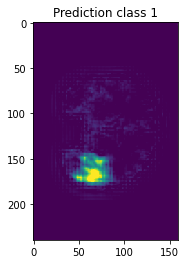

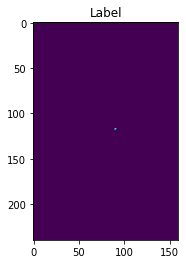

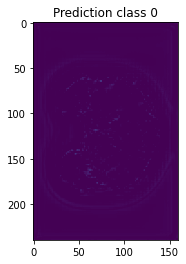

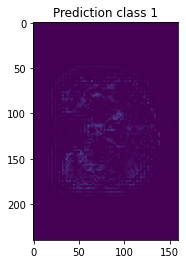

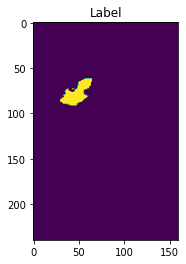

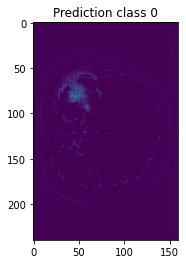

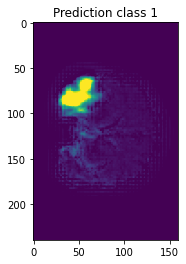

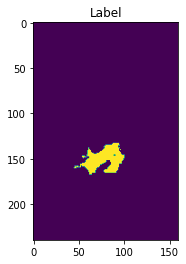

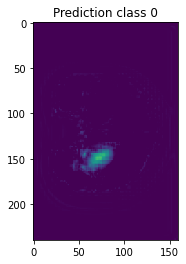

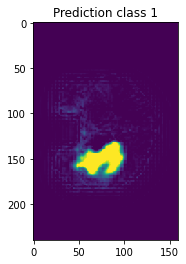

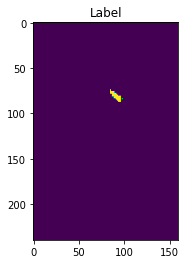

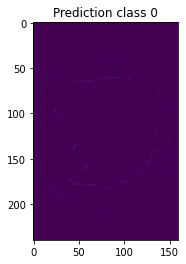

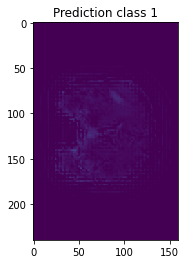

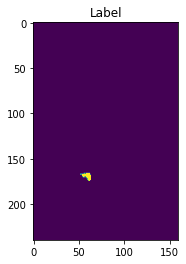

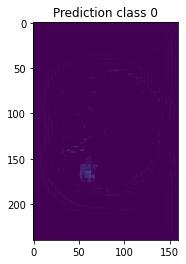

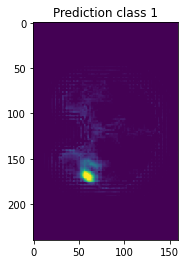

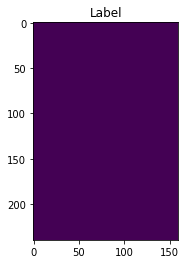

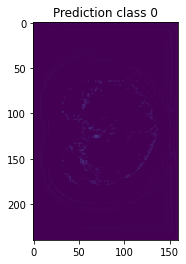

KeyboardInterrupt: ignored

In [ ]:
# Example code for crudely showing some images
# Probably best in another notebook, but w/e

model = TumourSegmentation.load_from_checkpoint('lightning_logs/version_1/checkpoints/epoch=1-step=598.ckpt').cuda().half()
# 1 for the tumor core
# 2 for edema
# 4 for surrounding
model.cuda().half()
for z in train_dataloader:
  print('======================================================')
  prediction = model.forward(torch.unsqueeze(z[0], axis=0).cuda().half())

  sl = z[1][0, :, 100]
  sl[sl==4] = 1

  plt.title('Label')
  plt.imshow(sl, vmin = 0, vmax=2)
  plt.show()

  prediction = prediction[0].cpu().detach().numpy().astype('float32')

  plt.title('Prediction class 0')
  plt.imshow(prediction[0, :, 100], vmin = 0, vmax=1)
  plt.show()

  plt.title('Prediction class 1')
  plt.imshow(prediction[1, :, 100], vmin = 0, vmax=1)
  plt.show()



def bbox2_3D(img):

    r = np.any(img, axis=(1, 2))
    c = np.any(img, axis=(0, 2))
    z = np.any(img, axis=(0, 1))

    rmin, rmax = np.where(r)[0][[0, -1]]
    cmin, cmax = np.where(c)[0][[0, -1]]
    zmin, zmax = np.where(z)[0][[0, -1]]

    return rmin, rmax, cmin, cmax, zmin, zmax
    

      xmins = []
      xmaxs = []
      ymins = []
      ymaxs = []
      zmins = []
      zmaxs = []
      for img in [f_flair, f_seg, f_t1ce, f_t1, f_t2]:
        xmin, xmax, ymin, ymax, zmin, zmax = bbox2_3D(img)
        xmins.append(xmin)
        xmaxs.append(xmax)
        ymins.append(ymin)
        ymaxs.append(ymax)
        zmins.append(zmin)
        zmaxs.append(zmax)
      xmin = np.min(xmin)
      ymin = np.min(ymin)
      zmin = np.min(zmin)
      xmax = np.max(xmax)
      ymax = np.max(ymax)
      zmax = np.max(zmax)

      f_flair = f_flair[xmin:xmax, ymin:ymax, zmin:zmax]
      f_seg = f_seg[xmin:xmax, ymin:ymax, zmin:zmax]
      f_t1ce = f_t1ce[xmin:xmax, ymin:ymax, zmin:zmax]
      f_t1 = f_t1[xmin:xmax, ymin:ymax, zmin:zmax]
      f_t2 = f_t2[xmin:xmax, ymin:ymax, zmin:zmax]

      print(f_flair.shape)